In [52]:
import torch 
from torch import nn 
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import resnet18

In [53]:
augmentation1 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(105, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(105, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [54]:
class BYOLDataset(Dataset):
    def __init__(self, base_dataset, transform1, transform2):
        self.base_dataset = base_dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx] 
        x1 = self.transform1(img)
        x2 = self.transform2(img)
        return x1, x2

In [55]:
dataset_path = "./dataset"
base_dataset = datasets.ImageFolder(root=dataset_path)
byol_dataset = BYOLDataset(base_dataset, augmentation1, augmentation2)
dataloader = torch.utils.data.DataLoader(byol_dataset, batch_size=32, shuffle=True)

In [56]:
data_iter = iter(dataloader)
x1, x2 = next(data_iter)
print(x1.shape) 
print(x2.shape) 


torch.Size([32, 1, 105, 105])
torch.Size([32, 1, 105, 105])


In [57]:
data_iter = iter(dataloader)
images, labels = next(data_iter)
images.shape

torch.Size([32, 1, 105, 105])

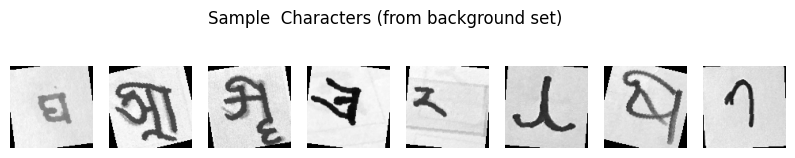

In [58]:
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].squeeze(0).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample  Characters (from background set)")
plt.show()

In [59]:
class Encoder(nn.Module):
    def __init__(self, pretrained=True, out_dim=128):
        super(Encoder, self).__init__()
        base_model = resnet18(pretrained=pretrained)

        # Modify first conv layer to accept 1-channel input instead of 3
        original_conv1 = base_model.conv1
        base_model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias is not None
        )

        # Optional: initialize weights of new conv1
        if pretrained:
            with torch.no_grad():
                # Copy weights from RGB to 1-channel (average over input channels)
                base_model.conv1.weight = nn.Parameter(
                    base_model.conv1.weight.mean(dim=1, keepdim=True)
                )

        self.features = nn.Sequential(*list(base_model.children())[:-1])  # up to avgpool
        self.flatten = nn.Flatten()
        self.projection = nn.Linear(512, out_dim)

    def forward(self, x):
        x = self.features(x)      # (B, 512, 1, 1)
        x = self.flatten(x)       # (B, 512)
        x = self.projection(x)    # (B, 128)
        return x


In [60]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [61]:
class OnlineNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=128, proj_hidden_dim=256, proj_out_dim=128):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)
        self.predictor = MLP(proj_out_dim, proj_hidden_dim // 2, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        predictions = self.predictor(projections)
        return predictions, projections

In [62]:
class TargetNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return projections


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [64]:
encoder = Encoder()

online_net = OnlineNetwork(encoder, feature_dim=128, proj_hidden_dim=256, proj_out_dim=256)
target_net = TargetNetwork(encoder, feature_dim=128, proj_hidden_dim=256, proj_out_dim=256)
online_net.to(device)
target_net.to(device)

TargetNetwork(
  (encoder): Encoder(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, ep

In [65]:
def loss_fn(p, z):
    p = F.normalize(p, dim=-1)
    z = F.normalize(z.detach(), dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

In [66]:
@torch.no_grad()
def update_target_network(online_net, target_net, beta=0.996):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = beta * param_t.data + (1 - beta) * param_o.data

In [67]:
# Count parameters
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

def count_parameters_by_layer(model):
    """Count parameters by layer and show detailed breakdown"""
    total_params = 0
    trainable_params = 0
    
    print("Parameter count by layer:")
    print("-" * 50)
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
            print(f"{name}: {param_count:,} parameters (trainable)")
        else:
            print(f"{name}: {param_count:,} parameters (frozen)")
    
    print("-" * 50)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    
    return total_params, trainable_params

# Count parameters for online network
print("ONLINE NETWORK PARAMETER COUNT:")
print("=" * 50)
total_params, trainable_params = count_parameters_by_layer(online_net)

# Also show a simple count
simple_count = count_parameters(online_net)
print(f"\nSimple parameter count: {simple_count:,}")

# Convert to millions for easier reading
print(f"Parameters in millions: {simple_count / 1e6:.2f}M")

ONLINE NETWORK PARAMETER COUNT:
Parameter count by layer:
--------------------------------------------------
encoder.features.0.weight: 3,136 parameters (trainable)
encoder.features.1.weight: 64 parameters (trainable)
encoder.features.1.bias: 64 parameters (trainable)
encoder.features.4.0.conv1.weight: 36,864 parameters (trainable)
encoder.features.4.0.bn1.weight: 64 parameters (trainable)
encoder.features.4.0.bn1.bias: 64 parameters (trainable)
encoder.features.4.0.conv2.weight: 36,864 parameters (trainable)
encoder.features.4.0.bn2.weight: 64 parameters (trainable)
encoder.features.4.0.bn2.bias: 64 parameters (trainable)
encoder.features.4.1.conv1.weight: 36,864 parameters (trainable)
encoder.features.4.1.bn1.weight: 64 parameters (trainable)
encoder.features.4.1.bn1.bias: 64 parameters (trainable)
encoder.features.4.1.conv2.weight: 36,864 parameters (trainable)
encoder.features.4.1.bn2.weight: 64 parameters (trainable)
encoder.features.4.1.bn2.bias: 64 parameters (trainable)
encoder

In [ ]:
lr = 1e-5
weight_decay = 1e-6  
epochs = 100

optimizer = torch.optim.Adam(online_net.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, verbose=True
)

online_net = online_net.to(device)
target_net = target_net.to(device)
target_net.eval()

best_loss = float('inf')
epoch_losses = [] 

for epoch in range(epochs):
    online_net.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for x1, x2 in loop:
        x1, x2 = x1.to(device), x2.to(device)

        optimizer.zero_grad()

        # Online forward
        p1, z1 = online_net(x1)

        with torch.no_grad():
            z2 = target_net(x2)

        loss1 = loss_fn(p1, z2)

        # Second view
        p2, z2_online = online_net(x2)

        with torch.no_grad():
            z1_target = target_net(x1)

        loss2 = loss_fn(p2, z1_target)

        # Total loss
        loss = (loss1 + loss2) / 2
        loss.backward()
        optimizer.step()

        # Update target net
        update_target_network(online_net, target_net, beta=0.996)

        total_loss += loss.item()
        avg_loss = total_loss / (loop.n + 1)
        loop.set_postfix(loss=avg_loss)

    # Epoch average loss
    total_loss_epoch = total_loss / len(dataloader)
    epoch_losses.append(total_loss_epoch)  # Save for plotting
    print(f"Epoch {epoch+1} Final Avg Loss: {total_loss_epoch:.4f}")

    # Step the scheduler
    scheduler.step(total_loss_epoch)

    # Save best model
    if total_loss_epoch < best_loss:
        best_loss = total_loss_epoch
        torch.save(target_net.encoder.state_dict(), 'best_model.pth')

print("\nBest Validation Loss:", best_loss)


Epoch [1/100]: 100%|██████████| 186/186 [02:52<00:00,  1.08it/s, loss=1.68]


Epoch 1 Final Avg Loss: 1.6797


Epoch [2/100]: 100%|██████████| 186/186 [02:42<00:00,  1.14it/s, loss=1.18]


Epoch 2 Final Avg Loss: 1.1771


Epoch [3/100]: 100%|██████████| 186/186 [02:45<00:00,  1.12it/s, loss=0.787]


Epoch 3 Final Avg Loss: 0.7866


Epoch [4/100]: 100%|██████████| 186/186 [02:48<00:00,  1.11it/s, loss=0.529]


Epoch 4 Final Avg Loss: 0.5290


Epoch [5/100]: 100%|██████████| 186/186 [02:54<00:00,  1.07it/s, loss=0.356]


Epoch 5 Final Avg Loss: 0.3561


Epoch [6/100]:   5%|▍         | 9/186 [00:08<02:49,  1.05it/s, loss=0.295]

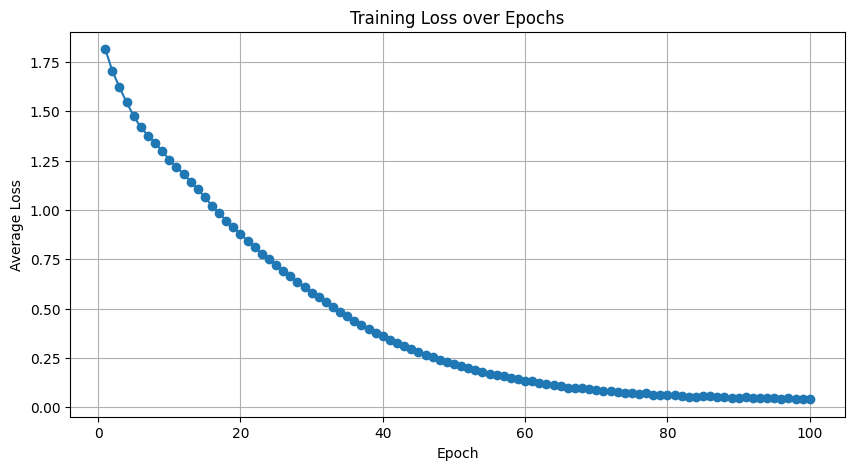

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()